<a href="https://colab.research.google.com/github/lnreinhard/master-thesis/blob/main/LSTM_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright notice

Code adapted from https://gitlab.com/radufotolescu/useful/-/blob/master/kaggle/nlp-disaster-tweets/5_baseline_models.ipynb 

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install libraries

In [ ]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

# Data import

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab/lstm/data/colab/train.csv', delimiter='\t', index_col=0)
df2 = pd.read_csv('/content/drive/MyDrive/Colab/lstm/data/colab/validation.csv', delimiter='\t', index_col=0)
df3 = pd.read_csv('/content/drive/MyDrive/Colab/lstm/data/colab/test.csv', delimiter='\t', index_col=0)

In [ ]:
df = pd.concat([df1, df2, df3], ignore_index=True, sort=False)

In [ ]:
df = df[['label', 'text']]
df['label'] = df['label'].replace('positive', 0)
df['label'] = df['label'].replace('negative', 1)
df['label'] = df['label'].replace('neutral', 2)
df['label'] = df['label'].astype(str).astype(int)
df.dropna(inplace=True)
df.reset_index(drop=True)

,label,text
0,0,Executive Board receives a new shareholder req...
1,0,"London, 31st May 2019 - MBH Corporation plc (""..."
2,1,HanseYachts AG. ISIN: DE000A0KF6M8. WKN: A0KF6...
3,1,Leclanché SA reports 2012 financial results . ...
4,1,The Management Board of Energiekontor AG today...
...,...,...
12301,0,Insider information according to Article 17 MA...
12302,1,"In June 2013, EVN AG brought claims against th..."
12303,1,Senvion S.A revises guidance for fiscal year 2...
12304,0,Ad hoc release according to article 17 MAR Pla...


# Preprocessing

## Remove punctuation

In [ ]:
import string

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [ ]:
df['text'] = df.text.map(lambda x: remove_punct(x))

## Remove stopwords

In [ ]:
import nltk
nltk.download('stopwords')
  
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['text'] = df['text'].map(remove_stopwords)

## Set length of dictionary

In [ ]:
from collections import Counter

# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
text = df.text

counter = counter_word(text)
num_words = len(counter)

# Max number of words in a sequence
max_length = 512

## Create test and train dataset

In [ ]:
train_size = int(df.shape[0] * 0.8)

train_sentences = df.text[:train_size]
train_labels = df.label[:train_size]

test_sentences = df.text[train_size:]
test_labels = df.label[train_size:]

## Tokenize sentences

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
word_index

{'million': 1,
 'eur': 2,
 'year': 3,
 'ag': 4,
 'board': 5,
 'company': 6,
 'shares': 7,
 'group': 8,
 'financial': 9,
 'new': 10,
 'capital': 11,
 'share': 12,
 'management': 13,
 '2020': 14,
 'business': 15,
 'first': 16,
 'increase': 17,
 'sales': 18,
 'chf': 19,
 '2019': 20,
 'previous': 21,
 'market': 22,
 'quarter': 23,
 'offer': 24,
 'per': 25,
 '2018': 26,
 'growth': 27,
 'net': 28,
 'expected': 29,
 '2017': 30,
 'today': 31,
 '2013': 32,
 'shareholders': 33,
 'supervisory': 34,
 'revenue': 35,
 '2012': 36,
 'earnings': 37,
 'ebit': 38,
 '2014': 39,
 'may': 40,
 'annual': 41,
 'meeting': 42,
 'cash': 43,
 'also': 44,
 'price': 45,
 'development': 46,
 'exchange': 47,
 'general': 48,
 '2016': 49,
 'total': 50,
 'result': 51,
 '2015': 52,
 'operating': 53,
 'ebitda': 54,
 'isin': 55,
 'securities': 56,
 '1': 57,
 'percent': 58,
 'due': 59,
 'period': 60,
 'stock': 61,
 'revenues': 62,
 'increased': 63,
 'well': 64,
 'amount': 65,
 'current': 66,
 'companys': 67,
 'results': 68,


In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)

In [ ]:
train_sequences[0]

[75,
 5,
 2119,
 10,
 272,
 963,
 2677,
 392,
 42,
 10570,
 34,
 5,
 7270,
 392,
 42,
 158,
 504,
 353,
 187,
 20,
 223,
 405,
 187,
 20,
 31,
 75,
 5,
 2093,
 4,
 55,
 9169,
 5846,
 11764,
 11765,
 6,
 235,
 3479,
 392,
 48,
 42,
 158,
 504,
 353,
 187,
 20,
 3378,
 244,
 681,
 117,
 1115,
 550,
 483,
 1594,
 332,
 82,
 26,
 48,
 42,
 2472,
 8,
 892,
 33,
 772,
 5412,
 404,
 5412,
 108,
 426,
 295,
 326,
 67,
 12,
 11,
 75,
 5,
 235,
 16188,
 18231,
 48,
 42,
 59,
 5297,
 10,
 854,
 1376,
 75,
 5,
 496,
 6,
 33,
 1174,
 3004,
 143,
 1669,
 264,
 6,
 5724,
 2120,
 2603,
 4960,
 392,
 48,
 42,
 1198,
 1115,
 3378,
 3867,
 433,
 198,
 377,
 83,
 1638,
 75,
 5,
 520,
 963,
 692,
 272,
 6,
 180,
 4590,
 142,
 87,
 9548,
 729,
 167,
 67,
 12,
 11,
 2677,
 137,
 392,
 48,
 42,
 257,
 397,
 2133,
 2030,
 57,
 134,
 61,
 597,
 138,
 1160,
 9548,
 2472,
 3258,
 125,
 550,
 471,
 1115,
 437,
 57,
 17,
 211,
 34,
 5,
 325,
 139,
 2510,
 158,
 258,
 914,
 325,
 188,
 1304,
 385,
 34,
 5,
 145,
 95

## Pad sequences to length 512

In [ ]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [ ]:
train_padded[0]

array([   75,     5,  2119,    10,   272,   963,  2677,   392,    42,
       10570,    34,     5,  7270,   392,    42,   158,   504,   353,
         187,    20,   223,   405,   187,    20,    31,    75,     5,
        2093,     4,    55,  9169,  5846, 11764, 11765,     6,   235,
        3479,   392,    48,    42,   158,   504,   353,   187,    20,
        3378,   244,   681,   117,  1115,   550,   483,  1594,   332,
          82,    26,    48,    42,  2472,     8,   892,    33,   772,
        5412,   404,  5412,   108,   426,   295,   326,    67,    12,
          11,    75,     5,   235, 16188, 18231,    48,    42,    59,
        5297,    10,   854,  1376,    75,     5,   496,     6,    33,
        1174,  3004,   143,  1669,   264,     6,  5724,  2120,  2603,
        4960,   392,    48,    42,  1198,  1115,  3378,  3867,   433,
         198,   377,    83,  1638,    75,     5,   520,   963,   692,
         272,     6,   180,  4590,   142,    87,  9548,   729,   167,
          67,    12,

In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [ ]:
print(df.text[0])
print(train_sequences[0])

executive board receives new shareholder request convene extraordinary meeting enlarge supervisory board postpones extraordinary meeting currently scheduled 26 february 2019 berlin 24 february 2019 today executive board mologen ag isin de000a2lq900 sin a2l q90 company decided postpone extraordinary general meeting currently scheduled 26 february 2019 convened publication invitation including agenda items federal gazette 21 december 2018 general meeting requested group minority shareholders led balaton aktiengesellschaft balaton holding together approx 7 companys share capital executive board decided calloff reschedule general meeting due occurrence new events opinion executive board provide company shareholders opportunity discuss future governance strategy company constructive manner stakeholders occasion extraordinary general meeting extended agenda convened earliest possible date decision based fact executive board received request principal shareholder company global derivative tra

In [ ]:
print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (9844, 512)
Shape of test (2462, 512)


In [ ]:
Y = pd.get_dummies(df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12306, 3)


In [ ]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Model creation

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam, SGD

model = Sequential()

model.add(Embedding(num_words, 64, input_length=max_length))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 512, 64)           4231296   
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 130       
Total params: 4,305,730
Trainable params: 4,305,730
Non-trainable params: 0
_________________________________________________________________


# Model training

In [ ]:
history = model.fit(
    train_padded, train_labels, epochs=6, batch_size=64, validation_split=0.1 ,
)

Epoch 1/6
139/139 [==============================] - 16s 94ms/step - loss: 0.6930 - accuracy: 0.5104 - val_loss: 0.6915 - val_accuracy: 0.5431
Epoch 2/6
139/139 [==============================] - 12s 86ms/step - loss: 0.6920 - accuracy: 0.5215 - val_loss: 0.6906 - val_accuracy: 0.5431
Epoch 3/6
139/139 [==============================] - 12s 86ms/step - loss: 0.6920 - accuracy: 0.5161 - val_loss: 0.6895 - val_accuracy: 0.5431
Epoch 4/6
139/139 [==============================] - 12s 85ms/step - loss: 0.6908 - accuracy: 0.5183 - val_loss: 0.6828 - val_accuracy: 0.5553
Epoch 5/6
139/139 [==============================] - 12s 87ms/step - loss: 0.6709 - accuracy: 0.6431 - val_loss: 0.6763 - val_accuracy: 0.6010
Epoch 6/6
139/139 [==============================] - 12s 88ms/step - loss: 0.5759 - accuracy: 0.7086 - val_loss: 0.7129 - val_accuracy: 0.5817


# Model evaluation

In [ ]:
results = model.evaluate(test_padded, test_labels)
print(results)

77/77 [==============================] - 1s 19ms/step - loss: 0.6974 - accuracy: 0.5845
[0.697361171245575, 0.5844841599464417]


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

rounded_labels=np.argmax(test_labels, axis=1)
classes = np.argmax(model.predict(test_padded), axis=-1)

accuracy = accuracy_score(rounded_labels, classes)
print('Accuracy: %.3f' % accuracy)

loss = results[0]
print('    Loss: %.3f' % loss)

f1 = f1_score(rounded_labels, classes, average='macro')
print('F1 score: %.3f' % f1)

Accuracy: 0.584
    Loss: 0.697
F1 score: 0.584


#Plot

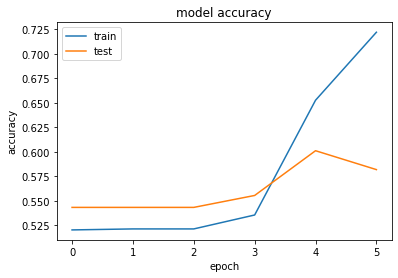

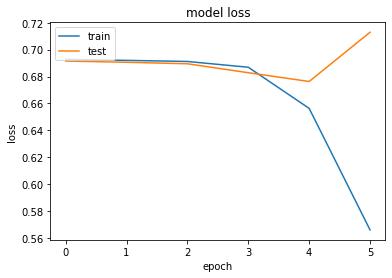

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()